----

# Time Series Analysis and Forecasting using Autoregressive Models

Data Source: https://www.kaggle.com/bappekim/air-pollution-in-seoul/data#Measurement_info.csv

Data Source: https://data.seoul.go.kr/dataList/OA-15526/S/1/datasetView.do#

----

In [36]:
import pandas as pd
import numpy as np
from datetime import timedelta
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
%matplotlib inline

Units for each pollutant are measured in Parts Per Million

In [37]:
#units of measurement
units = pd.read_csv('Measurement_item_info.csv')
units

,Item code,Item name,Unit of measurement,Good(Blue),Normal(Green),Bad(Yellow),Very bad(Red)
0,1,SO2,ppm,0.02,0.05,0.15,1.0
1,3,NO2,ppm,0.03,0.06,0.20,2.0
2,5,CO,ppm,2.00,9.00,15.00,50.0
3,6,O3,ppm,0.03,0.09,0.15,0.5
4,8,PM10,Mircrogram/m3,30.00,80.00,150.00,600.0
5,9,PM2.5,Mircrogram/m3,15.00,35.00,75.00,500.0


In [38]:
#read in the data and assign it to main
main_df = pd.read_csv('Measurement_summary.csv',
                   parse_dates=['Measurement date'],
                   index_col='Measurement date')

print(main_df.info())
main_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 647511 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Station code  647511 non-null  int64  
 1   Address       647511 non-null  object 
 2   Latitude      647511 non-null  float64
 3   Longitude     647511 non-null  float64
 4   SO2           647511 non-null  float64
 5   NO2           647511 non-null  float64
 6   O3            647511 non-null  float64
 7   CO            647511 non-null  float64
 8   PM10          647511 non-null  float64
 9   PM2.5         647511 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 54.3+ MB
None


,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,,,,,
2017-01-01 00:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.059,0.002,1.2,73.0,57.0
2017-01-01 01:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.058,0.002,1.2,71.0,59.0
2017-01-01 02:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,59.0
2017-01-01 03:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,58.0
2017-01-01 04:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.003,0.051,0.002,1.2,69.0,61.0


Data is collected from 2017-01 until 2019-12. For this use case we will work with the index column (Measurement Date) and the pollutant columns (SO2, NO2, O3, CO, PM10, PM2.5)

In [39]:
ap_data = main_df.iloc[:,[4,5,6,7,8,9]]
print(ap_data.head())
ap_data.describe()

                       SO2    NO2     O3   CO  PM10  PM2.5
Measurement date                                          
2017-01-01 00:00:00  0.004  0.059  0.002  1.2  73.0   57.0
2017-01-01 01:00:00  0.004  0.058  0.002  1.2  71.0   59.0
2017-01-01 02:00:00  0.004  0.056  0.002  1.2  70.0   59.0
2017-01-01 03:00:00  0.004  0.056  0.002  1.2  70.0   58.0
2017-01-01 04:00:00  0.003  0.051  0.002  1.2  69.0   61.0


,SO2,NO2,O3,CO,PM10,PM2.5
count,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000
mean,-0.001795,0.022519,0.017979,0.509197,43.708051,25.411995
std,0.078832,0.115153,0.099308,0.405319,71.137342,43.924595
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.003000,0.016000,0.008000,0.300000,22.000000,11.000000
50%,0.004000,0.025000,0.021000,0.500000,35.000000,19.000000
75%,0.005000,0.038000,0.034000,0.600000,53.000000,31.000000
max,3.736000,38.445000,33.600000,71.700000,3586.000000,6256.000000


Resample dataset to a daily frequency based on the last value for each day and plot a pair plot to observe correlations between pollutants 

Scale the values to observe correlations in a scatter plot

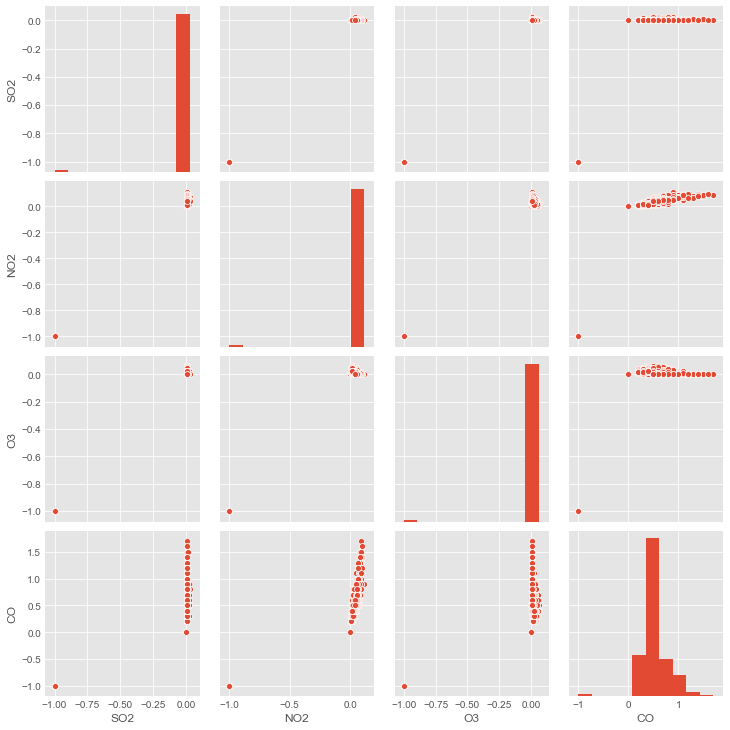

In [41]:
#resample the dataset based on daily frequency and last value for each day
ap_daily_data = ap_data.resample('D').last().dropna()

#seaborn pairplot to observe correlations between variables
sns.pairplot(ap_daily_data.iloc[:,[0,1,2,3]])
plt.style.use('seaborn-dark')
plt.style.use('ggplot')
plt.show()

----------
# Outlier Treatment
----------
Outliers are treated in two different ways in this dataset:
- Centering and Scaling based on z-scores
- Inter Quartile Range Rule

In [42]:
#Detect outliers using z_scores
from scipy import stats

#get the absolute value of z-score
z_scores = np.abs(stats.zscore(ap_daily_data))
print(z_scores)

#set a threshold and display rows with value indices where the data points are outliers
#the first array is the set of row numbers and the second array are indices on those rows which refer to outliers
threshold = 3
print('\n',np.where(z_scores>threshold))

[[9.88376757e-02 2.38980655e-01 3.46260535e-02 1.36739720e+00
  2.05065400e+00 1.67804464e+00]
 [9.87872081e+00 9.70330336e+00 9.80224581e+00 5.55351938e+00
  1.52129913e+00 1.35675661e+00]
 [1.08775483e-01 3.80878143e-01 3.46260535e-02 1.73165597e+00
  1.85989549e-01 4.16760725e-02]
 ...
 [8.88998684e-02 1.25462664e-01 5.38168293e-03 2.74620896e-01
  8.58413302e-02 1.60644011e-01]
 [8.88998684e-02 1.29952815e-01 1.79832664e-01 4.53896639e-01
  4.86434205e-01 4.46316239e-01]
 [8.88998684e-02 1.06542999e-01 5.38168293e-03 8.96378718e-02
  5.86582423e-01 3.95736218e-01]]

 (array([   1,    1,    1,    1,   14,   14,   14,   14,   15,   16,   17,
         17,   17,   17,   20,   20,   20,   20,   21,   21,   21,   21,
         23,   23,   23,   23,   24,   24,   24,   24,   25,   25,   25,
         25,   27,   27,   27,   27,   28,   28,   28,   28,   45,   77,
         78,   78,  124,  127,  356,  362,  362,  363,  363,  379,  380,
        380,  421,  435,  435,  447,  448,  460,  472,  

In [43]:
#Detect outliers using IQR
q1 = ap_daily_data.quantile(0.25)
q3 = ap_daily_data.quantile(0.75)
IQR = q3 - q1
print("\nThe Inter Quartile Range(Q3 - Q1) for the data set is: ")
print(IQR)

#Print boolean values for all data points which are outside the 3rd and 1st quartiles
print("\nTrue indicates the presence of outliers which are below Q1 or outside Q3.")
print((ap_daily_data<(q1 - 1.5*IQR)) | (ap_daily_data>(q3+1.5*IQR)))


The Inter Quartile Range(Q3 - Q1) for the data set is: 
SO2       0.002
NO2       0.032
O3        0.022
CO        0.200
PM10     32.000
PM2.5    20.000
dtype: float64

True indicates the presence of outliers which are below Q1 or outside Q3.
                    SO2    NO2     O3     CO   PM10  PM2.5
Measurement date                                          
2017-01-01        False  False  False   True   True  False
2017-01-02         True   True   True   True  False  False
2017-01-03        False  False  False   True  False  False
2017-01-04        False  False  False   True  False  False
2017-01-05        False  False  False  False  False  False
...                 ...    ...    ...    ...    ...    ...
2019-12-27        False  False  False  False  False  False
2019-12-28        False  False  False  False  False  False
2019-12-29        False  False  False  False  False  False
2019-12-30        False  False  False  False  False  False
2019-12-31        False  False  False  False  Fal

The following cell is used to create two scenarios where outliers are removed using z-scores and the IQR rule. Using the IQR rule reduces the dataset significantly. For the purpose of including as many data points as we can, the z-score method for outlier removal is used. Due to the presence of outliers with high leverage, the correlations observed earlier were not descriptive of the generic nature of variables in this dataset. Through the exclusion of some outliers we aim to observe these correlations in a more general manner. However, outlier removal must be paid careful attentions as only those points justify removal which are considered bad data or calculation errors. Another option to be considered instead of outlier removal is correction for bias in data.

In [44]:
#Removing outliers using z-scores
ap_daily_data_1 = ap_daily_data[(z_scores<threshold).all(axis=1)]

print("Using z-scores")
print('Shape of data before outlier removal: ', ap_daily_data.shape)
print('Shape of data after outlier removal: ', ap_daily_data_1.shape)

#Remove outliers using IQR
ap_daily_data_2 = ap_daily_data[~((ap_daily_data<(q1-1.5*IQR)) | (ap_daily_data>(q3+1.5*IQR))).any(axis=1)]

print("\nUsing the IQR Rule")
print('Shape of data before outlier removal: ', ap_daily_data.shape)
print('Shape of data after outlier removal: ', ap_daily_data_2.shape)

Using z-scores
Shape of data before outlier removal:  (1085, 6)
Shape of data after outlier removal:  (1039, 6)

Using the IQR Rule
Shape of data before outlier removal:  (1085, 6)
Shape of data after outlier removal:  (921, 6)


----

## Correlation matrix and scatter plots

----

In [45]:
#create a consistent data range and reindex the dataframe 
index = pd.date_range(start=ap_daily_data_1.index[0], end=ap_daily_data_1.index[-1], freq='D')
ap_daily_data_1 = ap_daily_data_1.reindex(index)


#interpolate missing values
ap_daily_data_1 = ap_daily_data_1.interpolate()
ap_daily_data_1

,SO2,NO2,O3,CO,PM10,PM2.5
2017-01-01,0.0040,0.0510,0.002,0.90,106.0,59.0
2017-01-02,0.0045,0.0585,0.002,0.95,72.5,42.0
2017-01-03,0.0050,0.0660,0.002,1.00,39.0,25.0
2017-01-04,0.0050,0.0650,0.002,1.20,82.0,60.0
2017-01-05,0.0030,0.0190,0.023,0.30,5.0,4.0
...,...,...,...,...,...,...
2019-12-27,0.0030,0.0550,0.002,0.70,50.0,29.0
2019-12-28,0.0040,0.0500,0.002,0.70,59.0,36.0
2019-12-29,0.0030,0.0390,0.005,0.60,42.0,29.0
2019-12-30,0.0030,0.0120,0.024,0.40,30.0,17.0


Removing extreme outliers results in more descriptive plots between variables and it can be seen now that there are significant positive associations between all pollutants. Due to correlations between variables there is a possibility for cointegration to exist. We further model $SO_{2}$ using its lagged values and forecast 5 days in the future. Forecast for $SO_{2}$ is finally presented as a single dataframe along with actual values. 

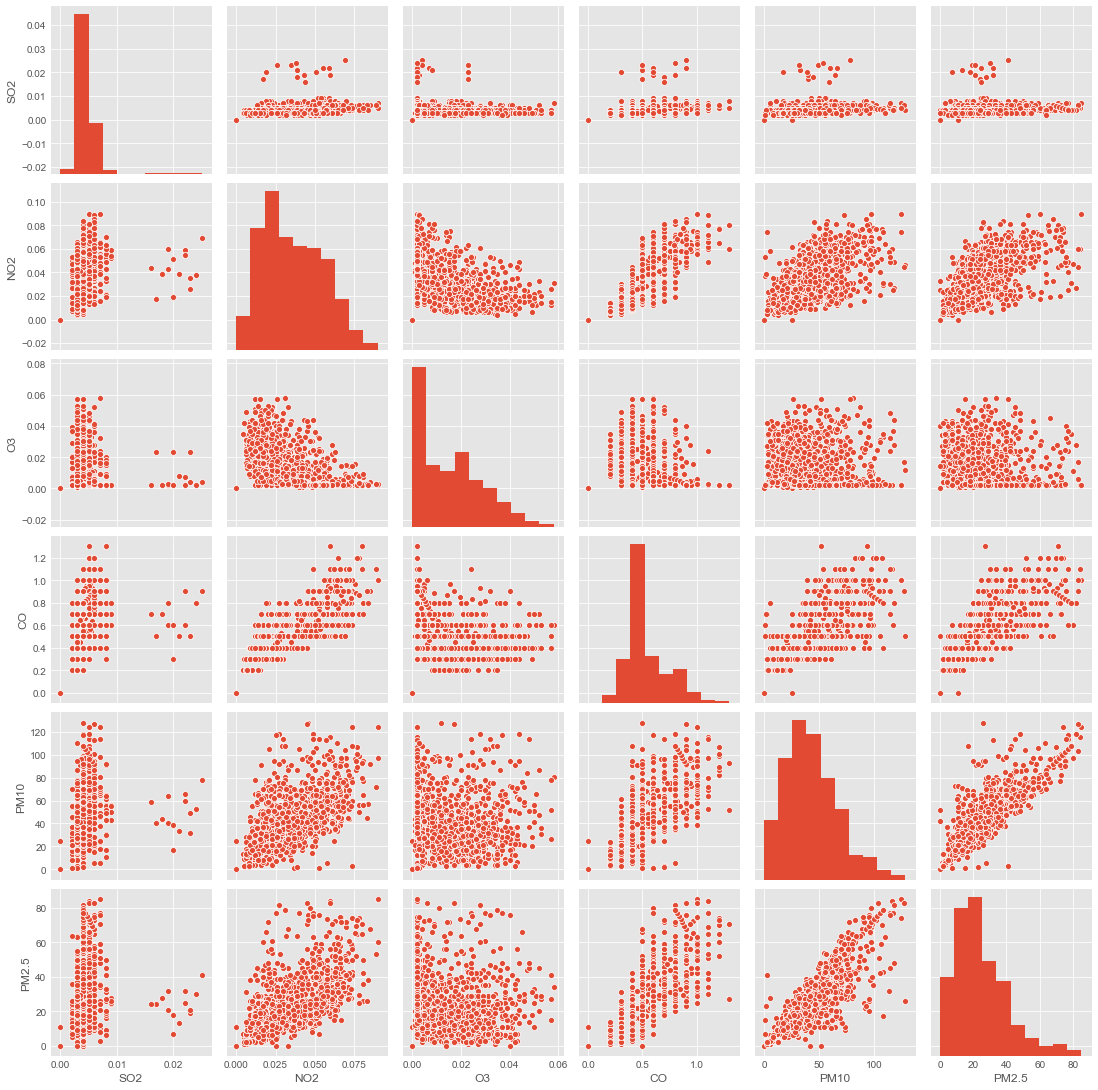

In [46]:
#pair plot after interpolation and outlier removal
ax = sns.pairplot(ap_daily_data_1)
plt.style.use('ggplot')
plt.show()

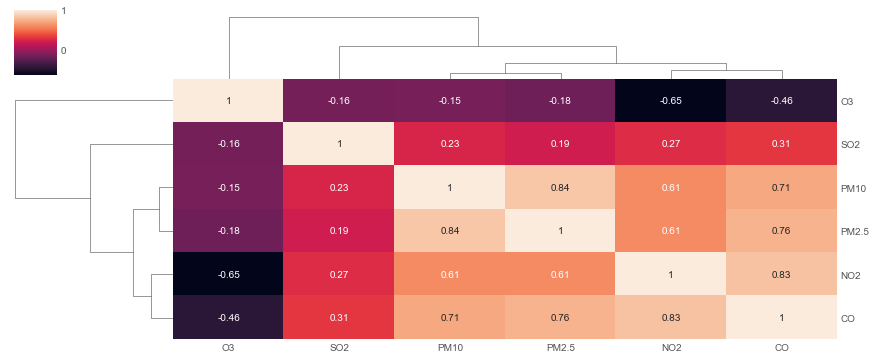

In [12]:
#dataframe constructed using z-score outlier removal
corr = ap_daily_data_1.corr(method='pearson')

fig = sns.clustermap(corr,
                    annot=True,
                    row_cluster=True,
                    col_cluster=True,
                    figsize=(12,5))
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

----
#### Modeling of SO2 in Seoul
----

The modeling procedure for $SO_{2}$ inlcudes:
- Observing the distribution of data
- Performming an Augmented Dicky Fuller Test, with a significance level of 0.05, to test for stationarity
- Checking for Autocorrelations
- Checking for Partial Autocorrelations
- Seasonal Decomposition
- Building a model using grid parameter optimization from pmdarima

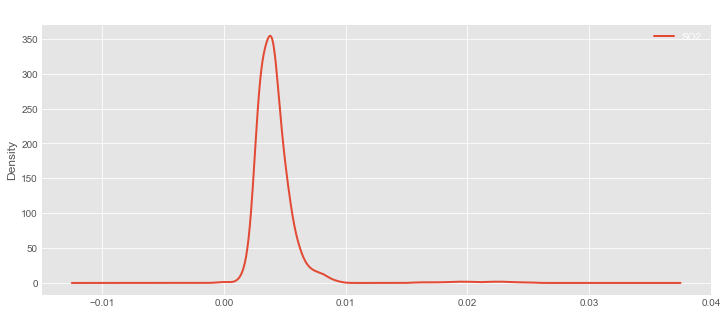

P-value of Augmented Dicky Fuller test:  0.002
SO2 series is stationary


,SO2
2017-01-01,0.0040
2017-01-02,0.0045
2017-01-03,0.0050
2017-01-04,0.0050
2017-01-05,0.0030


In [49]:
#data frame for SO2
so2 = ap_daily_data_1.iloc[:,[0]]

#plot a density plot to see the distribution  of so2
ax = so2.plot(kind='density', linewidth=2)
ax.set_title('Distribution of SO2 in Seoul')
plt.style.use('seaborn-dark')
plt.show()

#check if the series is stationary
adf = adfuller(so2)
print('P-value of Augmented Dicky Fuller test: ', round(adf[1],3))
if adf[1]<0.05:
    print('SO2 series is stationary')
else:
    print('SO2 series is not stationary')
    

so2.head()

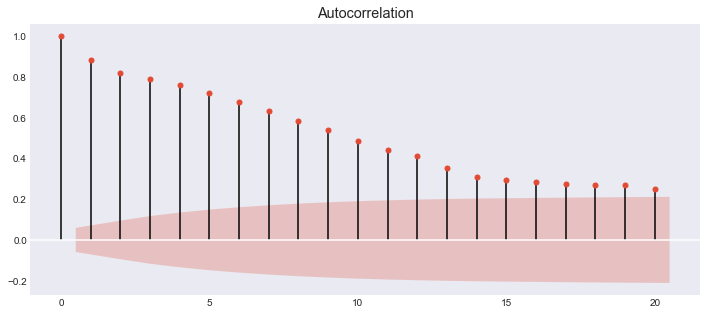

The autocorrelation plot shows that up to 19 lags are significanlty different than 0 and can be used to base inferences on future value(s)


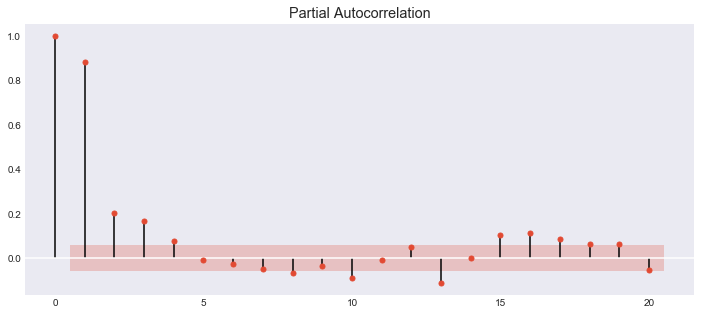

The partial autocorrelation plot shows that only 3 lags are significantly different than 0.


In [50]:
# observe autocorrelations and partial autocorrelations
plot_acf(so2, lags=20, alpha= 0.05)
plt.show()
print('The autocorrelation plot shows that up to 19 lags are significanlty different than 0 and can be used to base inferences on future value(s)')


#observe Partial Autocorrelations
plot_pacf(so2, lags= 20, alpha=0.05)
plt.show()
print('The partial autocorrelation plot shows that only 3 lags are significantly different than 0.')

The seasonal decomposition of $SO_{2}$ shows that there is almost a negligible trend, however when observed at monthly intervals there is a seasonal component to the data.

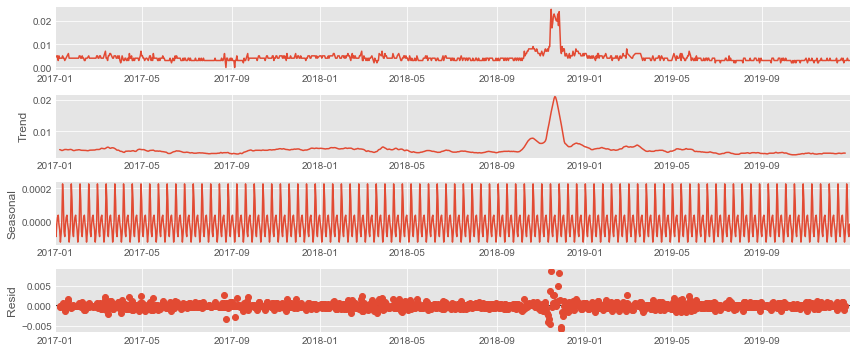

In [53]:
#Seasonal decomposition of so2
rcParams['figure.figsize'] = 12,5
so2_decomp = seasonal_decompose(so2, model='additive', period=12)
so2_decomp.plot()
plt.style.use('dark_background')
plt.style.use('ggplot')
plt.show()

------------
# Model estimation, fitting, and forecast
-----------
- To estimate the model we use pmd arima with a grid search for parameters

In [21]:
mod = pmd.auto_arima(so2, seasonal=True, m=12, suppress_warnings=True, stepwise=False)
print('Optimal Model order:', mod.order)    

Optimal Model order: (3, 1, 0)


The optimal models is an ARIMA model with the following parameters:
- Autoregressive = 3
- Difference = 1
- Moving Average = 0

In [27]:
import warnings
warnings.simplefilter('ignore')

mod2 = SARIMAX(so2, order=mod.order)
mod2 = mod2.fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    SO2   No. Observations:                 1095
Model:               SARIMAX(3, 1, 0)   Log Likelihood                5977.660
Date:                Tue, 21 Apr 2020   AIC                         -11947.319
Time:                        22:33:02   BIC                         -11927.329
Sample:                    01-01-2017   HQIC                        -11939.755
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3182      0.009    -35.819      0.000      -0.336      -0.301
ar.L2         -0.2249      0.015    -14.734      0.000      -0.255      -0.195
ar.L3         -0.1000      0.020     -4.948      0.000      -0.140      -0.060
sigma2      1.051e-06   1.43e-08     73.560      0.000    1.02e-06    1.08e-06
===================================================================================
Ljung-Box (Q):                      123.78   Jarque-Bera (JB):             30643.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.51
Prob(H) (two-sided):                  0.14   Kurtosis:                        28.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- A data range is created which is consistent with the original data frame and the final forecasts. These dates are also used to forecast over the next 5 days, and a final data frame is created which consists of actual values and forecasted values.

In [30]:
dates = pd.date_range(start=so2.index[0], end=so2.index[-1]+timedelta(5), freq='D')
so2_final = so2.reindex(dates)
so2_final['Forecast'] = mod2.predict(start=so2_final.index[0], end=so2_final.index[-1]+timedelta(5), typ='levels')

In [31]:
#Final Forecast
final_forecast = so2_final.tail(20).fillna('-')
final_forecast

,SO2,Forecast
2019-12-17,0.003,0.002975
2019-12-18,0.003,0.002900
2019-12-19,0.0035,0.003000
2019-12-20,0.004,0.003341
2019-12-21,0.003,0.003728
2019-12-22,0.004,0.003156
2019-12-23,0.002,0.003857
2019-12-24,0.003,0.002511
2019-12-25,0.003,0.003032
2019-12-26,0.003,0.002975


This final graph plots the $SO_{2}$ dataframe to show the output of the model in comparison to the actual values and a 5 day forward forecast.

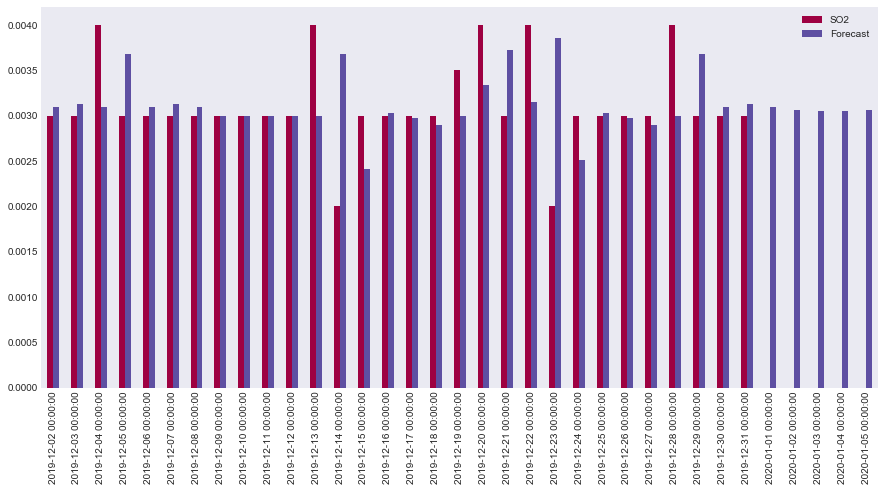

In [35]:
ax = so2_final[so2_final.index>'2019-12-01'].plot(kind='bar',colormap='Spectral', figsize=(15,7))
plt.style.use('seaborn-dark')
plt.show()